### Composite AGN Cutout Query Creator
This notebook will create `SQL` query requests for a series of cutout images of a specific single quasar to create training data for the transfer-learning phase on real data for `DualFinder`

In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors, cm
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import glob
import scipy
import csv
import pandas as pd
import matplotlib.image as mpimg
from astropy.table import Table
from tqdm.notebook import tqdm,trange
import requests
import time
import tarfile
from schwimmbad import MultiPool
import multiprocess as mp
from astropy.io import fits
import matplotlib as mpl
import os
from os.path import exists
import shutil
import requests
from offset_AGN_dataset_creator import DatasetCreator
%load_ext autoreload
%autoreload 2


In [2]:
print(os.getcwd())
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_R/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_G/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_Z/")
#os.makedirs("Rotated_AGN_diff_fltrs/HSC_Y/")

/vast/palmer/scratch/urry/iam37/Project_DRAGON/DRAGON_CNN


In [3]:
def imgdwnldr_gen(args):
    
    df,num_start,num_stop,fltr = args
    
    t = Table()
    t["rerun"] = ["pdr3_wide"]*len(df[num_start:num_stop])
    t["filter"] = [fltr]*len(df[num_start:num_stop])
    #t["tract"] = df["tract"][num_start:num_stop]
    t["ra"] = df["ra"][num_start:num_stop]
    t["dec"] = df["dec"][num_start:num_stop]
    t["type"] = ["coadd"]*len(df[num_start:num_stop])
    t["sh"] = ["16asec"]*len(df[num_start:num_stop])
    t["sw"] = ["16asec"]*len(df[num_start:num_stop])
    t["name"] = df["name"][num_start:num_stop]
                  
    return t

In [4]:
def table_writer(args):
    
    table, i, filepath_prefix, overwrite, tableformat, comment= args
    #os.chdir(filepath_prefix)
    #print("CURRENT WORKING DIRECTORY: " + str(os.getcwd()))
    table.write(filepath_prefix + "download_sql" + ".txt",
                overwrite=overwrite,format=tableformat,
                comment=comment)
    #os.chdir("/Users/moskowitzi/Library/CloudStorage/Dropbox/First_Year_at_Yale/Summer_2022/Quasar_Research")
#args = (test2DF, 0, 35, "HSC-R")
#secondTestTable = imgdwnldr_gen(args)
#filepath_prefix = 'input_second_test_HSC_new'
def write_dwnldr_files(df,step,filepath_prefix = None,write=True,
                      overwrite=True, fltr = None):   
                  
    len_df = len(df)
    iters = int(len_df/step)
    #print(len_df)
    lwr_ends = range(0,len_df,step)
    upr_ends = range(step,len_df+step,step)
    fltrs = [fltr]*(iters+1)
    dfs = [df]*(iters+1)
    
    args_imgdwnldr_gen = list(zip(dfs,lwr_ends,upr_ends,fltrs))
    #args_imgdwnldr_gen = (dfs,lwr_ends,upr_ends,fltrs)
    #imgdwnldr_gen(args_imgdwnldr_gen)
    with mp.Pool() as pool:
        tables = list(tqdm(pool.imap(imgdwnldr_gen,args_imgdwnldr_gen), total = iters+1))
    
    if write is True:
        paths = [filepath_prefix]*(iters+1)
        overwrites = [overwrite]*(iters+1)
        tableformats = ['ascii.commented_header']*(iters+1)
        comments = ["#?"]*(iters+1)
        i_s = np.arange(iters+1)
    
        args_table_writer = list(zip(tables,i_s,paths,overwrites,tableformats,comments))
        #args_table_writer = (tables,i_s,paths,overwrites,tableformats,comments)
        #table_writer(args_table_writer)
        
        with mp.Pool() as pool:
            exit_codes = list(tqdm(pool.imap(table_writer,args_table_writer), total = iters+1))
        print("got here after table writer")
        
    else:
        for table in tables:
            print(table)
    return tables
def write_rotation_test_coordinates(quasarName, separation, raStart, decStart, fltr):
    count = 0
    degree_separation = separation/3600
    raList = []
    decList = []
    quasarNameList = []
    for i in np.arange(0, 2*np.pi, np.pi/18):
        ra = raStart + degree_separation* np.cos(i)
        dec = decStart + degree_separation* np.sin(i)
        raList.append(ra)
        decList.append(dec)
        quasarNameNew = quasarName + "_HSC_" + str(fltr) + "_rotated_" + str(count) + "_degrees"
        print(quasarNameNew)
        quasarNameList.append(quasarNameNew)
        count+=10
    return raList, decList, quasarNameList
#Automatic downloaders for downloading from HSC servers:
def cutout_requester(args):
    
    session, listpath_prefix, write_path_prefix, i = args
    print(f"listpath_prefix: {listpath_prefix}")
    print(f"write_path_prefix: {write_path_prefix}")
    
    files = {
        'list': (listpath_prefix + "download_sql.txt", open(listpath_prefix + "download_sql.txt", 'rb')),
    }
    
    with session.post('https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout', 
                      files=files, auth=('moskowitzi', 'UCiNwD3CHzbprC8G1QM2aUxpQIZdp2cOjyQWOO7J'), stream=True) as response:
        
        total_size = int(response.headers.get('content-length', 0))
        chunk_size = len(i)  # Define chunk size
        
        with open(write_path_prefix + "download.tar", 'wb') as f, tqdm(
            total=total_size, unit='B', unit_scale=True, desc=write_path_prefix + "download.tar") as progress_bar:
            
            for chunk in response.iter_content(chunk_size):
                if chunk:  # Filter out keep-alive new chunks
                    f.write(chunk)
                    progress_bar.update(len(chunk))
def members(tf):
    
    for i, member in enumerate(tf.getmembers()):
        if i == 0:
            l = len(member.path.split("/")[0]) + 1
        
        member.path = member.path[l:]
        yield member
def write_band_download_cutouts(quasarNameList, raList, decList, fltr, filepath, filepath_prefix, separation):
    
    header = ['ra', 'dec', 'name']
   
    #if not (exists(filepath) or exists(filepath_prefix)):
        #os.makedirs(filepath)
        #os.makedirs(filepath_prefix)
    if not exists(filepath):
        os.makedirs(filepath)
    if not exists(filepath_prefix):
        os.makedirs(filepath_prefix)
    with open(filepath + "catalog_" + str(separation) + ".csv", 'w', encoding = 'UTF8') as f: 
        writer = csv.writer(f)
        writer.writerow(header)
        for j in range(len(raList)):
            #print("raList[j]: " + str(raList[j]))
            #print(type(raList[j]))
            combinedData = [raList[j], decList[j], quasarNameList[j]]
            writer.writerow(combinedData)
    #print("got here")
    test_df = pd.read_csv(filepath + "catalog_" + str(separation) + ".csv", delimiter = ',')
    write = True
    overwrite = True
    #print(test_df)
    write_dwnldr_files(test_df, fltr = fltr, step=len(raList), write=write,overwrite=overwrite,
                filepath_prefix = filepath_prefix)
        
#Function to actuall extract all the tarballs
def extractor(args):
    tar_file_prefix, write_path, i = args
    
    with tarfile.open(tar_file_prefix + f"download.tar") as tf:
        tf.extractall(write_path,members=members(tf))

In [5]:
def reducedAmplitudeTestFile(quasarName, percentage, separation, raStart, decStart, fltr, filepath = None):
    quasarName = quasarName
    
    #raStart = 154.60814662744912
    #decStart = 0.34943320872888634
    raList, decList, quasarNameList = write_rotation_test_coordinates(quasarName, separation, raStart, decStart, fltr)
    print("got here")
    header = ['ra', 'dec', 'name']
#args = secondTestTable, filepath_prefix, overwrite, tableformat, comment
#table_writer(args)
    print(len(quasarNameList))
    print(len(raList))
    print(len(decList))
    if not exists(filepath):
        os.makedirs(filepath)
    with open(filepath + "rotation_test_reduced_amplitude_"+str(separation)+".csv", 'w', encoding = 'UTF8') as f: 
        writer = csv.writer(f)
        writer.writerow(header)
        for j in range(len(raList)):
            combinedData = [raList[j], decList[j], quasarNameList[j]]
            writer.writerow(combinedData)
    #print("got here")
    test_df = pd.read_csv(filepath + "rotation_test_reduced_amplitude_"+str(separation)+".csv", delimiter = ',')
    write = True
    overwrite = True
    if not exists(filepath + "downloader_files/downloader_for_" + str((separation)) + "/"):
        os.makedirs(filepath + "downloader_files/downloader_for_" + str((separation)) + "/")
    tables = write_dwnldr_files(test_df,step=len(raList), fltr = fltr, write=write,overwrite=overwrite,
                filepath_prefix= filepath + "downloader_files/downloader_for_" + str((separation)) + "/")
    print(test_df)

In [ ]:
img = fits.getdata("cutout-HSC-G-9226-pdr3_wide-240530-152449.fits")
plt.imshow(img, vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))

In [ ]:
#os.chdir("/vast/palmer/scratch/urry/iam37/")
#All Spring Equitorial Quasars in SDSS and HSC
starttime = time.time()
fits_table_dr16q = 'DR16Q_v4.fits'
hdu1 = fits.open(fits_table_dr16q)
data = hdu1[1].data
min_row_fall_1 = 668635
max_row_fall_1 = 750414
min_row_fall_2 = 1
max_row_fall_2 = 116727
quasarNameList_fall = []
quasarRAList_fall = []
quasarDecList_fall = []
quasarZList_fall = []
"""Fall Equatorial Band"""
for j in range(min_row_fall_1, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "QSO" or data[j].field(7) == "QSO" or data[j].field(6) == data[j].field(7) == "QSO")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        #quasarNameNoSpaceNoPeriod = quasarNameNoSpace.replace(".", "_")
        #quasarNameNoPlus = quasarNameNoSpaceNoPeriod.replace("+", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_fall.append(inputQuasarName)
        quasarRAList_fall.append(data[j].field(1))
        quasarDecList_fall.append(data[j].field(2))
        quasarZList_fall.append(data[j].field(28))
for j in range(min_row_fall_2, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "QSO" or data[j].field(7) == "QSO" or data[j].field(6) == data[j].field(7) == "QSO")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_fall.append(inputQuasarName)
        quasarRAList_fall.append(data[j].field(1))
        quasarDecList_fall.append(data[j].field(2))
        quasarZList_fall.append(data[j].field(28))
quasarNameList_fall = np.asarray(quasarNameList_fall)
#for j in range(len(quasarNameList_fall)):
    #if quasarNameList_fall[j].find("QSO") == -1:
        #print(quasarNameList_fall[j])
        #print(j)
header = ['ra', 'dec', 'Quasar name', 'Z']
#print(len(quasarNameList))
if not exists("HSC_survey_bands/"):
    os.makedirs("HSC_survey_bands/")
with open("HSC_survey_bands/fall_equitorial_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_fall)):
        combinedData = [quasarRAList_fall[i], quasarDecList_fall[i], quasarNameList_fall[i], quasarZList_fall[i]]
        writer.writerow(combinedData)
fall_df = pd.read_csv("HSC_survey_bands/fall_equitorial_quasar_list.csv", delimiter=',')
#print(fall_df)
"""Spring Equatorial Band"""
valid_rows1 = data[170000:552181]
print(data[0][0])
print(data[0].field(2))
quasarNameList_spring = []
quasarRAList = []
quasarDecList = []
quasarZList = []
#We know that HSC's field contains RA = 130º at 199012, I will now test smaller RA's to see if they are also contained within the 
#survey field
for i in range(191617, 552181):
    if (data[i].field(2)>= -7.0 and data[i].field(2) <= 1.0 and (data[i].field(6) == "QSO" or data[i].field(7) == "QSO" or data[i].field(6) == data[i].field(7) == "QSO")):
        quasarName = data[i].field(6) + " " + data[i].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_spring.append(inputQuasarName)
        quasarRAList.append(data[i].field(1))
        quasarDecList.append(data[i].field(2))
        quasarZList.append(data[i].field(28))
quasarNameList_spring = np.asarray(quasarNameList_spring)
#for j in range(len(quasarNameList_spring)):
    #if quasarNameList_spring[j].find("QSO") == -1:
        #print(quasarNameList_spring[j])
        #print("Not a QSO Object")
        #print(j)
header = ['ra', 'dec', 'Quasar name']
print(len(quasarNameList_spring))
with open("HSC_survey_bands/spring_equitorial_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_spring)):
        combinedData = [quasarRAList[i], quasarDecList[i], quasarNameList_spring[i], quasarZList[i]]
        writer.writerow(combinedData)
spring_df = pd.read_csv("HSC_survey_bands/spring_equitorial_quasar_list.csv", delimiter=',')
#print(spring_df)
#for i in range(0, len(spring_df)):
    #numpyVersion = spring_df.loc[i].to_numpy()
    #print(numpyVersion)
    #if (numpyVersion[1] <=-6.0):
        #print("Something went wrong here")
        #print(spring_df.loc[i])
#display(spring_df.to_string())
"""
with open("spring_equitorial_quasar_list_hsc_download.csv", "w", encoding='UTF8') as p:
    writer = csv.writer(p)
    header = ["#?", "rerun", "filter", "ra", "dec", "sw", "sh", "name"]
    writer.writerow(header)
    for i in range(0, len(quasarNameList)):
        combinedData = [NaN, "pdr3_wide", "HSC-R", quasarRAList[i], quasarDecList[i], "0.01asec", "0.01asec", "spring_equitorial_"+str(i)]
        writer.writerow(combinedData)
"""
#print(quasarNameList)
#print(quasarZList)
#In this section of the download, we are working in the Spring Equitorial survey path, which goes from roughly
#120 degrees to 225 degrees of RA and -7 to 1 degrees of Dec
"""Northern Sky Band"""
min_row_north = 448834
max_row_north = 602111
quasarNameList_north = []
quasarRAList_north = []
quasarDecList_north = []
quasarZList_north = []
for k in range(min_row_north, max_row_north):
    if(data[k].field(2) >= 42.5 and data[k].field(2) <= 44.0 and (data[k].field(6) == "QSO" or data[k].field(7) == "QSO" or data[k].field(6) == data[k].field(7) == "QSO")):
        quasarName = data[k].field(6) + " " + data[k].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        quasarNameList_north.append(inputQuasarName)
        quasarRAList_north.append(data[k].field(1))
        quasarDecList_north.append(data[k].field(2))
        quasarZList_north.append(data[k].field(28))
quasarNameList_north = np.asarray(quasarNameList_north)
#for k in range(len(quasarNameList_north)):
    #if quasarNameList_north[k].find("QSO") == -1:
        #print(quasarNameList_north[k])
        #print(k)
print(len(quasarNameList_north))
print("Total number of QSO objects = " + str(len(quasarNameList_fall) + len(quasarNameList_spring) + len(quasarNameList_north)))
with open("HSC_survey_bands/northern_sky_quasar_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(quasarNameList_north)):
        combinedData = [quasarRAList_north[i], quasarDecList_north[i], quasarNameList_north[i], quasarZList_north[i]]
        writer.writerow(combinedData)
northern_df = pd.read_csv("HSC_survey_bands/northern_sky_quasar_list.csv", delimiter=',')
endtime = time.time()
print("--- %s seconds ---" % (endtime - starttime))

In [7]:

#All Spring Equitorial Quasars in SDSS and HSC
starttime = time.time()
fits_table_dr16q = '../DR16Q_v4.fits'
hdu1 = fits.open(fits_table_dr16q)
data = hdu1[1].data
min_row_fall_1 = 668635
max_row_fall_1 = 750414
min_row_fall_2 = 1
max_row_fall_2 = 116727
star_name_list_fall = []
star_ra_list_fall = []
star_dec_list_fall = []
star_z_list_fall = []
"""Fall Equatorial Band"""
for j in range(min_row_fall_1, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "STAR" or data[j].field(7) == "STAR" or data[j].field(6) == data[j].field(7) == "STAR")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        star_name_list_fall.append(inputQuasarName)
        star_ra_list_fall.append(data[j].field(1))
        star_dec_list_fall.append(data[j].field(2))
        star_z_list_fall.append(data[j].field(28))
for j in range(min_row_fall_2, max_row_fall_2):
    if(data[j].field(2) >= -1.0 and data[j].field(2) <= 7.0 and (data[j].field(6) == "STAR" or data[j].field(7) == "STAR" or data[j].field(6) == data[j].field(7) == "STAR")):
        quasarName = data[j].field(6) + " " + data[j].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        star_name_list_fall.append(inputQuasarName)
        star_ra_list_fall.append(data[j].field(1))
        star_dec_list_fall.append(data[j].field(2))
        star_z_list_fall.append(data[j].field(28))

header = ['ra', 'dec', 'star name', 'Z']
#print(len(quasarNameList))
if not exists("HSC_survey_bands/"):
    os.makedirs("HSC_survey_bands/")
with open("HSC_survey_bands/fall_equitorial_star_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(star_name_list_fall)):
        combinedData = [star_ra_list_fall[i], star_dec_list_fall[i], star_name_list_fall[i], star_z_list_fall[i]]
        writer.writerow(combinedData)
fall_df = pd.read_csv("HSC_survey_bands/fall_equitorial_star_list.csv", delimiter=',')

"""Spring Equatorial Band"""
valid_rows1 = data[170000:552181]

star_name_list_spring = []
star_ra_list_spring = []
star_dec_list_spring = []
star_z_list_spring = []
#We know that HSC's field contains RA = 130º at 199012, I will now test smaller RA's to see if they are also contained within the 
#survey field
for i in range(191617, 552181):
    if (data[i].field(2)>= -7.0 and data[i].field(2) <= 1.0 and (data[i].field(6) == "STAR" or data[i].field(7) == "STAR" or data[i].field(6) == data[i].field(7) == "STAR")):
        quasarName = data[i].field(6) + " " + data[i].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        star_name_list_spring.append(inputQuasarName)
        star_ra_list_spring.append(data[i].field(1))
        star_dec_list_spring.append(data[i].field(2))
        star_z_list_spring.append(data[i].field(28))

header = ['ra', 'dec', 'star name']
print(len(quasarNameList_spring))
with open("HSC_survey_bands/spring_equitorial_star_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(star_name_list_spring)):
        combinedData = [star_ra_list_spring[i], star_dec_list_spring[i], star_name_list_spring[i], star_z_list_spring[i]]
        writer.writerow(combinedData)
spring_df = pd.read_csv("HSC_survey_bands/spring_equitorial_star_list.csv", delimiter=',')

"""Northern Sky Band"""
min_row_north = 448834
max_row_north = 602111
star_name_list_north = []
star_ra_list_north = []
star_dec_list_north = []
star_z_list_north = []
for k in range(min_row_north, max_row_north):
    if(data[k].field(2) >= 42.5 and data[k].field(2) <= 44.0 and (data[k].field(6) == "STAR" or data[k].field(7) == "STAR" or data[k].field(6) == data[k].field(7) == "STAR")):
        quasarName = data[k].field(6) + " " + data[k].field(0)
        quasarNameNoSpace = quasarName.replace(" ", "_")
        inputQuasarName = quasarNameNoSpace
        star_name_list_north.append(inputQuasarName)
        star_ra_list_north.append(data[k].field(1))
        star_dec_list_north.append(data[k].field(2))
        star_z_list_north.append(data[k].field(28))

print("Total number of STAR objects = " + str(len(star_name_list_fall) + len(star_name_list_spring) + len(star_name_list_north)))
with open("HSC_survey_bands/northern_sky_star_list.csv", 'w', encoding='UTF8') as f:
    writer = csv.writer(f)
    writer.writerow(header)
    for i in range(0, len(star_name_list_north)):
        combinedData = [star_ra_list_north[i], star_dec_list_north[i], star_name_list_north[i], star_z_list_north[i]]
        writer.writerow(combinedData)
northern_df = pd.read_csv("HSC_survey_bands/northern_sky_star_list.csv", delimiter=',')
endtime = time.time()
print("--- %s seconds ---" % (endtime - starttime))

NameError: name 'quasarNameList_spring' is not defined

In [24]:
percentages = np.arange(0.1, 1.0, 0.1)
separations = np.arange(0.55, 2.5, 0.05)
angle = np.arange(0.0, 359.0, 1.0)
quasar_name = "QSO_000035.59-003146.1"
ra_start = 0.14833262219804055 + 0.55 * np.cos(0)/3600.0
dec_start = -0.5294901735587073
filepath = "Rotated_AGN_diff_fltrs/HSC_G/"
fltr = 'HSC-G'
for ii, percentage in tqdm(enumerate(percentages)):
    for j, angular_separation in enumerate(separations):
        angular_separation = np.round(angular_separation, 2)
        tables = reducedAmplitudeTestFile(quasar_name, percentage, angular_separation, ra_start, dec_start, fltr, filepath = filepath)


0it [00:00, ?it/s]

QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_120_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_130_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_140_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_150_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_160_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_170_degrees
QSO_000035.59-003146.1_HSC_HSC-G_rotated_180_degrees
QSO_

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148638 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148636 -0.529464  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148629 -0.529438  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148618 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148602 -0.529392  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148584 -0.529373  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148562 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148538 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148512 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148459 -0.529340  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148433 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148652 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148650 -0.529461  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148642 -0.529433  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148630 -0.529407  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148613 -0.529383  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148593 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148569 -0.529346  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148542 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148514 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148456 -0.529326  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148428 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1484

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148666 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148663 -0.529459  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148655 -0.529428  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148642 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148624 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148601 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148576 -0.529334  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148547 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148517 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148454 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148424 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148680 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148677 -0.529456  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148668 -0.529424  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148654 -0.529393  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148634 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148610 -0.529341  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148583 -0.529322  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148552 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148519 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148452 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148419 -0.529307  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148694 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148691 -0.529454  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148681 -0.529419  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148666 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148645 -0.529356  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148619 -0.529331  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148590 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148557 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148522 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148449 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148414 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148708 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148704 -0.529452  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148694 -0.529414  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148678 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148656 -0.529347  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148628 -0.529320  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148597 -0.529298  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148561 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148524 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148447 -0.529271  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148409 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148722 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148718 -0.529449  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148707 -0.529409  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148690 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148666 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148637 -0.529309  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148603 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148566 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148526 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148444 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148405 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148735 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148732 -0.529447  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148720 -0.529405  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148702 -0.529365  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148677 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148646 -0.529299  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148610 -0.529274  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148571 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148529 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148442 -0.529244  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148400 -0.529255  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148749 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148745 -0.529444  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148733 -0.529400  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148714 -0.529358  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148688 -0.529321  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148655 -0.529288  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148617 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148576 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148531 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148440 -0.529230  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148395 -0.529242  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148763 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148759 -0.529442  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148746 -0.529395  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148726 -0.529351  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148698 -0.529312  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148664 -0.529277  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148624 -0.529250  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148580 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148534 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148437 -0.529217  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148390 -0.529229  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148777 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148773 -0.529440  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148759 -0.529390  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148738 -0.529344  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148709 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148673 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148631 -0.529238  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148585 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148536 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148435 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148386 -0.529216  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148791 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148786 -0.529437  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148773 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148750 -0.529337  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148719 -0.529294  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148682 -0.529256  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148638 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148590 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148538 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148432 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148381 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148805 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148800 -0.529435  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148786 -0.529381  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148762 -0.529330  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148730 -0.529285  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148691 -0.529245  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148645 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148595 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148541 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148430 -0.529176  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148376 -0.529190  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148819 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148814 -0.529432  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148799 -0.529376  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148774 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148741 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148700 -0.529235  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148652 -0.529201  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148599 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148543 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148428 -0.529162  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148371 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148833 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148827 -0.529430  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148812 -0.529371  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148786 -0.529317  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148751 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148709 -0.529224  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148659 -0.529189  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148604 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148546 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529143  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148425 -0.529148  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148367 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148847 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148841 -0.529427  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148825 -0.529367  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148798 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148762 -0.529258  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148718 -0.529214  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148666 -0.529177  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148609 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148548 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148423 -0.529135  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148362 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1483

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148860 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148855 -0.529425  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148838 -0.529362  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148810 -0.529303  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148773 -0.529249  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148726 -0.529203  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148673 -0.529165  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148614 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148551 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148420 -0.529121  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148357 -0.529138  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148874 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148868 -0.529423  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148851 -0.529357  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148822 -0.529296  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148783 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148735 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148680 -0.529153  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148618 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148553 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529101  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148418 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148352 -0.529125  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148888 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148882 -0.529420  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148864 -0.529352  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148834 -0.529289  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148794 -0.529231  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148744 -0.529182  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148687 -0.529141  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148623 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148555 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529087  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148415 -0.529094  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148348 -0.529112  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148902 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148896 -0.529418  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148877 -0.529348  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148846 -0.529282  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148805 -0.529222  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148753 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148694 -0.529129  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148628 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148558 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529074  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148413 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148343 -0.529099  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148916 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148909 -0.529415  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148890 -0.529343  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148858 -0.529275  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148815 -0.529213  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148762 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148701 -0.529117  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148633 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148560 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529060  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148411 -0.529066  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148338 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148930 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148923 -0.529413  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148903 -0.529338  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148870 -0.529268  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148826 -0.529204  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148771 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148708 -0.529105  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148637 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148563 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148408 -0.529052  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148333 -0.529073  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148944 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148937 -0.529411  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148916 -0.529333  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148882 -0.529261  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148837 -0.529196  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148780 -0.529139  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148715 -0.529093  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148642 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148565 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529032  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148406 -0.529039  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148329 -0.529059  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148958 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148950 -0.529408  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148929 -0.529329  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148894 -0.529254  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148847 -0.529187  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148789 -0.529128  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148722 -0.529081  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148647 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148567 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529018  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148403 -0.529025  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148324 -0.529046  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148972 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148964 -0.529406  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148942 -0.529324  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148906 -0.529247  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148858 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148798 -0.529118  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148728 -0.529069  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148652 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148570 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.529004  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148401 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148319 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148985 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148978 -0.529403  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148955 -0.529319  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148918 -0.529240  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148868 -0.529169  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148807 -0.529107  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148735 -0.529057  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148656 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148572 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148399 -0.528998  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148314 -0.529020  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.148999 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.148991 -0.529401  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148968 -0.529314  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148930 -0.529233  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148879 -0.529160  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148816 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148742 -0.529045  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148661 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148575 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528976  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148396 -0.528984  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148310 -0.529007  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149013 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149005 -0.529399  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148981 -0.529310  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148942 -0.529226  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148890 -0.529151  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148825 -0.529086  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148749 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148666 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148577 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528962  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148394 -0.528970  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148305 -0.528994  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149027 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149019 -0.529396  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.148994 -0.529305  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148954 -0.529219  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148900 -0.529142  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148834 -0.529075  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148756 -0.529021  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148671 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148579 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148391 -0.528957  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148300 -0.528981  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149041 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149033 -0.529394  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149007 -0.529300  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148967 -0.529212  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148911 -0.529133  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148843 -0.529065  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148763 -0.529009  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148675 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148582 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528935  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148389 -0.528943  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148295 -0.528968  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149055 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149046 -0.529391  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149021 -0.529295  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148979 -0.529205  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148922 -0.529124  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148851 -0.529054  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148770 -0.528997  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148680 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148584 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528921  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148387 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148291 -0.528955  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1482

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149069 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149060 -0.529389  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149034 -0.529291  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.148991 -0.529199  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148932 -0.529115  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148860 -0.529043  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148777 -0.528985  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148685 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148587 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528907  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148384 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148286 -0.528942  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149083 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149074 -0.529386  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149047 -0.529286  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149003 -0.529192  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148943 -0.529106  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148869 -0.529033  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148784 -0.528973  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148690 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148589 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528893  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148382 -0.528902  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148281 -0.528929  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149097 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149087 -0.529384  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149060 -0.529281  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149015 -0.529185  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148954 -0.529097  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148878 -0.529022  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148791 -0.528961  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148694 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148592 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528879  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148379 -0.528888  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148276 -0.528916  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149110 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149101 -0.529382  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149073 -0.529276  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149027 -0.529178  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148964 -0.529088  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148887 -0.529011  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148798 -0.528949  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148699 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148594 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528865  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148377 -0.528875  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148272 -0.528903  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149124 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149115 -0.529379  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149086 -0.529272  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149039 -0.529171  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148975 -0.529080  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148896 -0.529001  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148805 -0.528937  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148704 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148596 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148374 -0.528861  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148267 -0.528890  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149138 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149128 -0.529377  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149099 -0.529267  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149051 -0.529164  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148985 -0.529071  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148905 -0.528990  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148812 -0.528925  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148709 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148599 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528837  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148372 -0.528847  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148262 -0.528877  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149152 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149142 -0.529374  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149112 -0.529262  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149063 -0.529157  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.148996 -0.529062  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148914 -0.528979  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148819 -0.528913  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148713 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148601 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528824  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148370 -0.528834  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148257 -0.528864  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

got here after table writer
          ra       dec                                               name
0   0.149166 -0.529490  QSO_000035.59-003146.1_HSC_HSC-G_rotated_0_deg...
1   0.149156 -0.529372  QSO_000035.59-003146.1_HSC_HSC-G_rotated_10_de...
2   0.149125 -0.529257  QSO_000035.59-003146.1_HSC_HSC-G_rotated_20_de...
3   0.149075 -0.529150  QSO_000035.59-003146.1_HSC_HSC-G_rotated_30_de...
4   0.149007 -0.529053  QSO_000035.59-003146.1_HSC_HSC-G_rotated_40_de...
5   0.148923 -0.528969  QSO_000035.59-003146.1_HSC_HSC-G_rotated_50_de...
6   0.148826 -0.528901  QSO_000035.59-003146.1_HSC_HSC-G_rotated_60_de...
7   0.148718 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_70_de...
8   0.148604 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_80_de...
9   0.148485 -0.528810  QSO_000035.59-003146.1_HSC_HSC-G_rotated_90_de...
10  0.148367 -0.528820  QSO_000035.59-003146.1_HSC_HSC-G_rotated_100_d...
11  0.148253 -0.528851  QSO_000035.59-003146.1_HSC_HSC-G_rotated_110_d...
12  0.1481

In [ ]:
#This script creates new 16asec x 16asec cutouts of QSO 101825.95+002057.9 to create dual AGN images that are upscaled to the correct size for the rest of the dataset
percentages = np.arange(0.1, 1.0, 0.1)
separations = np.arange(0.55, 2.5, 0.05)
angle = np.arange(0.0, 359.0, 1.0)
quasar_name = "QSO_101825.95+002057.9"
ra_start = 154.60814662744912 + 0.55 * np.cos(0)/3600.0
dec_start = 0.34943320872888634
filepath = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/HSC_G/"
fltr = 'HSC-G'
for ii, percentage in tqdm(enumerate(percentages)):
    for j, angular_separation in enumerate(separations):
        angular_separation = np.round(angular_separation, 2)
        tables = reducedAmplitudeTestFile(quasar_name, percentage, angular_separation, ra_start, dec_start, fltr, filepath = filepath)


In [ ]:
extract = True
        total_files = 3600

        i_s = np.arange(total_files)
        prefix = ["Rotated_AGN_diff_fltrs/" + fltr+"/downloader_files/downloader_for

In [ ]:
"""
import shutil
import requests
with mp.Pool(processes=total_threads) as pool:
            with requests.Session() as session: #just to keep things clearn
                try:
                    sessions = [session]*len(i_s)
                    args_cutout_requester = list(zip(sessions,prefix,write_path,i_s))
                    exit_codes = list(tqdm(pool.imap_unordered(cutout_requester,args_cutout_requester), total = len(i_s)))
                except:
                    continue
"""

In [6]:
def members(tarf):
    
    for i, member in enumerate(tarf.getmembers()):
        if i == 0:
            l = len(member.path.split("/")[0]) + 1
        
        member.path = member.path[l:]
        yield member
        
        
#Function to actuall extract all the tarballs
def extractor(args):
    tar_file_prefix, write_path, i = args
    
    with tarfile.open(tar_file_prefix + "download.tar") as tarf:
        tarf.extractall(write_path,members=members(tarf))

In [25]:
extract = True
for j, angular_separation in tqdm(enumerate(separations)):
    total_files = 1404

    i_s = np.arange(total_files)
    prefix = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/downloaded_images"
    dwnldr_txt_filepath = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloader_files/downloader_for_" + str(np.round(angular_separation, 2))+"/"
    write_path = "Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/opened_images"

    #if extract is True:
        #with mp.Pool() as p:
            #exit_codes = list(tqdm(p.imap_unordered(cutout_requester,requester_args), total=len(i_s)))
    total_threads = 2
    #url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout'
    if not exists("Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/"):
        os.makedirs("Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/")
    #with MultiPool(processes=2) as pool:
        #with requests.Session() as session: #just to keep things clearn
            #sessions = [session]*len(i_s)
            #args_cutout_requester = list(zip(sessions,dwnldr_txt_filepath,write_path,i_s))
            #exit_codes = list(tqdm(pool.imap_unordered(cutout_requester,args_cutout_requester), total = len(i_s)))
    with requests.Session() as session:
        args_cutout_requester = (session,dwnldr_txt_filepath,write_path,i_s)
        cutout_requester(args_cutout_requester)
    extractor_args = (write_path,prefix,i_s)
    extractor(extractor_args)
    #with open("Rotated_AGN_diff_fltrs/" + str(fltr)+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/" + "download.tar", 'wb') as out_file:

    #extractor_args = list(zip(prefix,write_path,i_s))
    #with mp.Pool() as p:
        #exit_codes = list(tqdm(p.imap_unordered(extractor,extractor_args), total=len(i_s)))

0it [00:00, ?it/s]

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.55/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.55_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.55_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.6/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.6_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.6_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.65/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.65_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.65_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.7/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.7_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.7_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.75/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.75_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.75_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.8/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.8_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.8_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.85/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.85_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.85_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.9/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.9_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.9_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_0.95/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.95_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/0.95_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.0/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.0_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.0_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.05/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.05_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.05_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.1/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.1_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.1_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.15/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.15_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.15_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.2/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.2_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.2_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.25/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.25_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.25_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.3/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.3_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.3_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.35/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.35_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.35_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.4/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.4_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.4_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.45/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.45_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.45_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.5/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.5_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.5_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.55/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.55_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.55_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.6/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.6_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.6_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.65/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.65_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.65_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.7/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.7_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.7_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.75/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.75_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.75_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.8/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.8_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.8_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.85/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.85_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.85_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.9/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.9_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.9_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_1.95/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.95_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/1.95_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.0/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.0_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.0_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.05/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.05_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.05_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.1/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.1_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.1_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.15/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.15_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.15_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.2/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.2_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.2_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.25/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.25_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.25_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.3/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.3_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.3_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.35/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.35_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.35_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.4/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.4_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.4_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00:…

listpath_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloader_files/downloader_for_2.45/
write_path_prefix: Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.45_arcsecond_separations/opened_images


Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/2.45_arcsecond_separations/opened_imagesdownload.tar: 0.00B [00…

In [ ]:
extract = True
for j, angular_separation in tqdm(enumerate(separations)):
    total_files = 1404

    i_s = np.arange(total_files)
    prefix = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/downloaded_images"
    dwnldr_txt_filepath = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloader_files/downloader_for_" + str(np.round(angular_separation, 2))+"/"
    write_path = "dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/opened_images"

    #if extract is True:
        #with mp.Pool() as p:
            #exit_codes = list(tqdm(p.imap_unordered(cutout_requester,requester_args), total=len(i_s)))
    total_threads = 2
    #url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout'
    if not exists("dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/"):
        os.makedirs("dual_AGN_training_data/Rotated_AGN_diff_fltrs/" + str("HSC_G")+ "/downloaded_images/" + str(np.round(angular_separation, 2))+"_arcsecond_separations/")
    with requests.Session() as session:
        args_cutout_requester = (session,dwnldr_txt_filepath,write_path,i_s)
        cutout_requester(args_cutout_requester)
    extractor_args = (write_path,prefix,i_s)
    extractor(extractor_args)

In [ ]:
bands = ["HSC-G", "HSC-R", "HSC-Z", "HSC-Y", "HSC-I"]
for fltr in tqdm(bands):
    print(fltr)
    total_files = 100000
    north_filepath_prefix = "entire_bands/" + str(fltr) + "/northern_sky/"
    fall_filepath_prefix = "entire_bands/" + str(fltr) + "/fall_equatorial/"
    spring_filepath_prefix = "entire_bands/" + str(fltr) + "/spring_equatorial/"
    i_s = np.arange(total_files)
    
    north_prefix = north_filepath_prefix + "downloaded_images/"
    north_dwnldr_txt_filepath = north_filepath_prefix
    north_write_path = north_filepath_prefix + "downloaded_images/opened_images"
    
    spring_prefix = spring_filepath_prefix + "downloaded_images/"
    spring_dwnldr_txt_filepath = spring_filepath_prefix
    spring_write_path = spring_filepath_prefix + "downloaded_images/opened_images"
    
    fall_prefix = fall_filepath_prefix + "downloaded_images/"
    fall_dwnldr_txt_filepath = fall_filepath_prefix
    fall_write_path = fall_filepath_prefix + "downloaded_images/opened_images"
    
    """if not exists(fall_prefix) and not exists(fall_dwnldr_txt_filepath) and not exists(fall_write_path):
        os.makedirs(fall_prefix)
        os.makedirs(fall_dwnldr_txt_filepath)
        os.makedirs(fall_write_path)
    if not exists(spring_prefix) and not exists(spring_dwnldr_txt_filepath) and not exists(spring_write_path):
        os.makedirs(spring_prefix)
        os.makedirs(spring_dwnldr_txt_filepath)
        os.makedirs(spring_write_path)
    if not exists(north_prefix) and not exists(north_dwnldr_txt_filepath) and not exists(north_write_path):
        os.makedirs(north_prefix)
        os.makedirs(north_dwnldr_txt_filepath)
        os.makedirs(north_write_path)"""
    write_band_download_cutouts(quasarNameList_fall, quasarRAList_fall, quasarDecList_fall, fltr, fall_dwnldr_txt_filepath, fall_filepath_prefix, 0.0)
    write_band_download_cutouts(quasarNameList_spring, quasarRAList, quasarDecList, fltr, spring_dwnldr_txt_filepath, spring_filepath_prefix, 0.0)
    write_band_download_cutouts(quasarNameList_north, quasarRAList_north, quasarDecList_north, fltr, north_dwnldr_txt_filepath, north_filepath_prefix, 0.0)

    total_threads = 2
    url = 'https://hsc-release.mtk.nao.ac.jp/das_cutout/pdr3/cgi-bin/cutout/'
    with requests.Session() as session:
        fall_args_cutout_requester = (session,fall_dwnldr_txt_filepath,fall_prefix,i_s)
        spring_args_cutout_requester = (session,spring_dwnldr_txt_filepath,spring_prefix,i_s)
        north_args_cutout_requester = (session,north_dwnldr_txt_filepath,north_prefix,i_s)
        print("Fall cutouts")
        cutout_requester(fall_args_cutout_requester)
        fall_extractor_args = (fall_write_path,fall_prefix,i_s)
        extractor(fall_extractor_args)
        
        print("Spring cutouts")
        cutout_requester(spring_args_cutout_requester)
        spring_extractor_args = (spring_write_path,spring_prefix,i_s)
        extractor(spring_extractor_args)
        
        print("North cutouts")
        cutout_requester(north_args_cutout_requester)
        spring_extractor_args = (north_write_path,north_prefix,i_s)
        extractor(north_extractor_args)
    

In [27]:

#!pwd
dataset_creation_session = DatasetCreator()
single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
rotated_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/"
fits_dual_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/train_data/"
dataset_creation_session.extract_single_galaxies(single_AGN_filepath)
dataset_creation_session.extract_rotated_AGN(rotated_AGN_filepath)
#dataset_creation_session.extract_single_point_sources(
dataset_creation_session.create_convolution(fits_dual_AGN_filepath)

2000it [00:01, 1995.80it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 63.95it/s]
10it [00:11,  1.20s/it]


KeyboardInterrupt: 

In [28]:
#Creates offset AGN images with downloaded confirmed non-merger galaxies. 
dataset_creation_session = DatasetCreator()
#single_AGN_filepath = "data_preprocessing/training_datasets/single_AGN_datasets/confirmed_single_AGN/"
single_galaxy_filepath = "../Rotated_AGN_diff_fltrs/HSC_G/filtered_ds/"
rotated_AGN_filepath = "data_preprocessing/training_datasets/dual_AGN_datasets/Rotated_AGN_diff_fltrs/HSC_G/downloaded_images/"
fits_dual_AGN_filepath = "data_preprocessing/training_datasets/offset_AGN_datasets/train_data/"
dataset_creation_session.extract_single_galaxies(single_galaxy_filepath)
dataset_creation_session.extract_rotated_AGN(rotated_AGN_filepath)
#dataset_creation_session.extract_single_point_sources(
dataset_creation_session.create_convolution(fits_dual_AGN_filepath)

121it [00:00, 1982.27it/s]
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:00<00:00, 64.24it/s]
20it [00:20,  1.04s/it]


KeyboardInterrupt: 

In [25]:
!pwd

/Users/moskowitzi/Library/CloudStorage/Dropbox/First_Year_at_Yale/Summer_2024/DRAGON_CNN


0it [00:00, ?it/s]

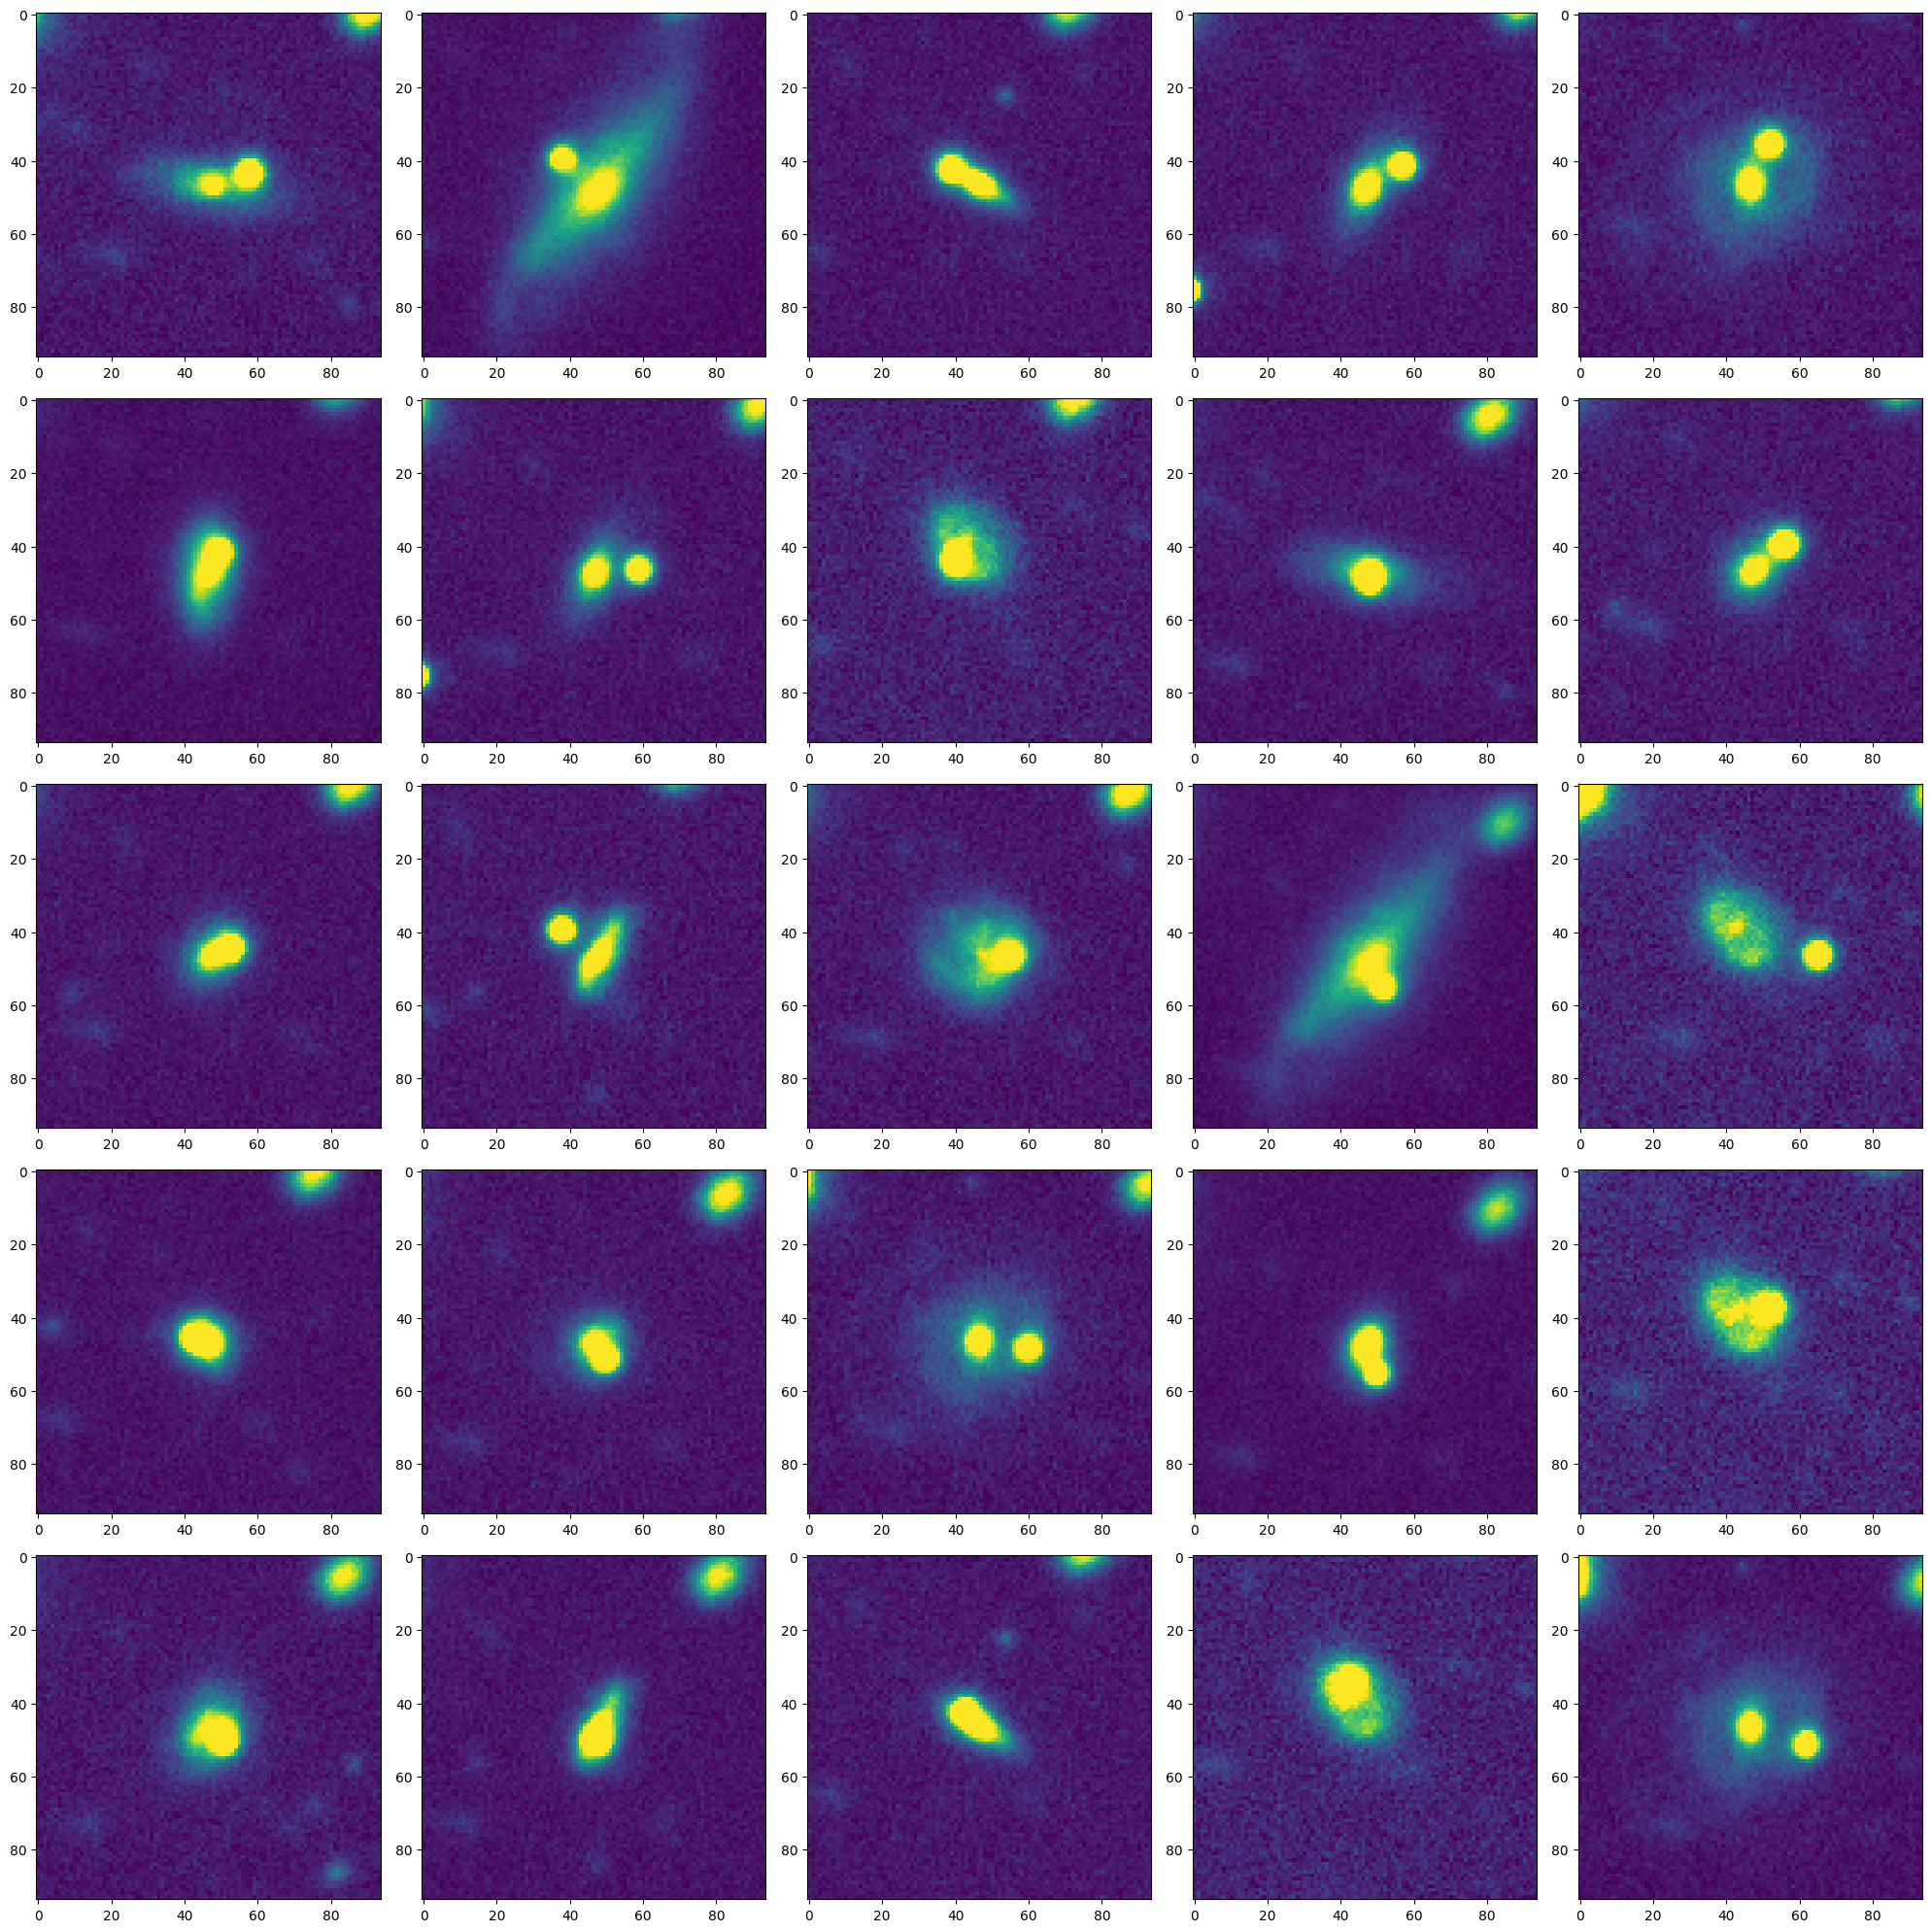

In [30]:
offset_training_images = []
for ii, image in tqdm(enumerate(glob.glob("data_preprocessing/training_datasets/offset_AGN_datasets/train_data/*.fits"))):
    with fits.open(image, memmap = False) as hdul:
        img = hdul[0].data
        if np.shape(img) != (94, 94):
            print(f"ERROR: image has shape {np.shape(img)}")
        offset_training_images.append(img)
        #print(f" {ii} images were successfully loaded, {image} is corrupted/could not be loaded")
    #except OSError:
random_offset_selection = np.random.choice(len(offset_training_images), size = 25)
fig, axes = plt.subplots(5, 5, figsize = (20,20))
counter = 0
for row in range(5):
    for col in range(5):
        img = offset_training_images[random_offset_selection[counter]]
        axes[row][col].imshow(img, vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))
        counter += 1
plt.tight_layout()
plt.show()

0it [00:00, ?it/s]

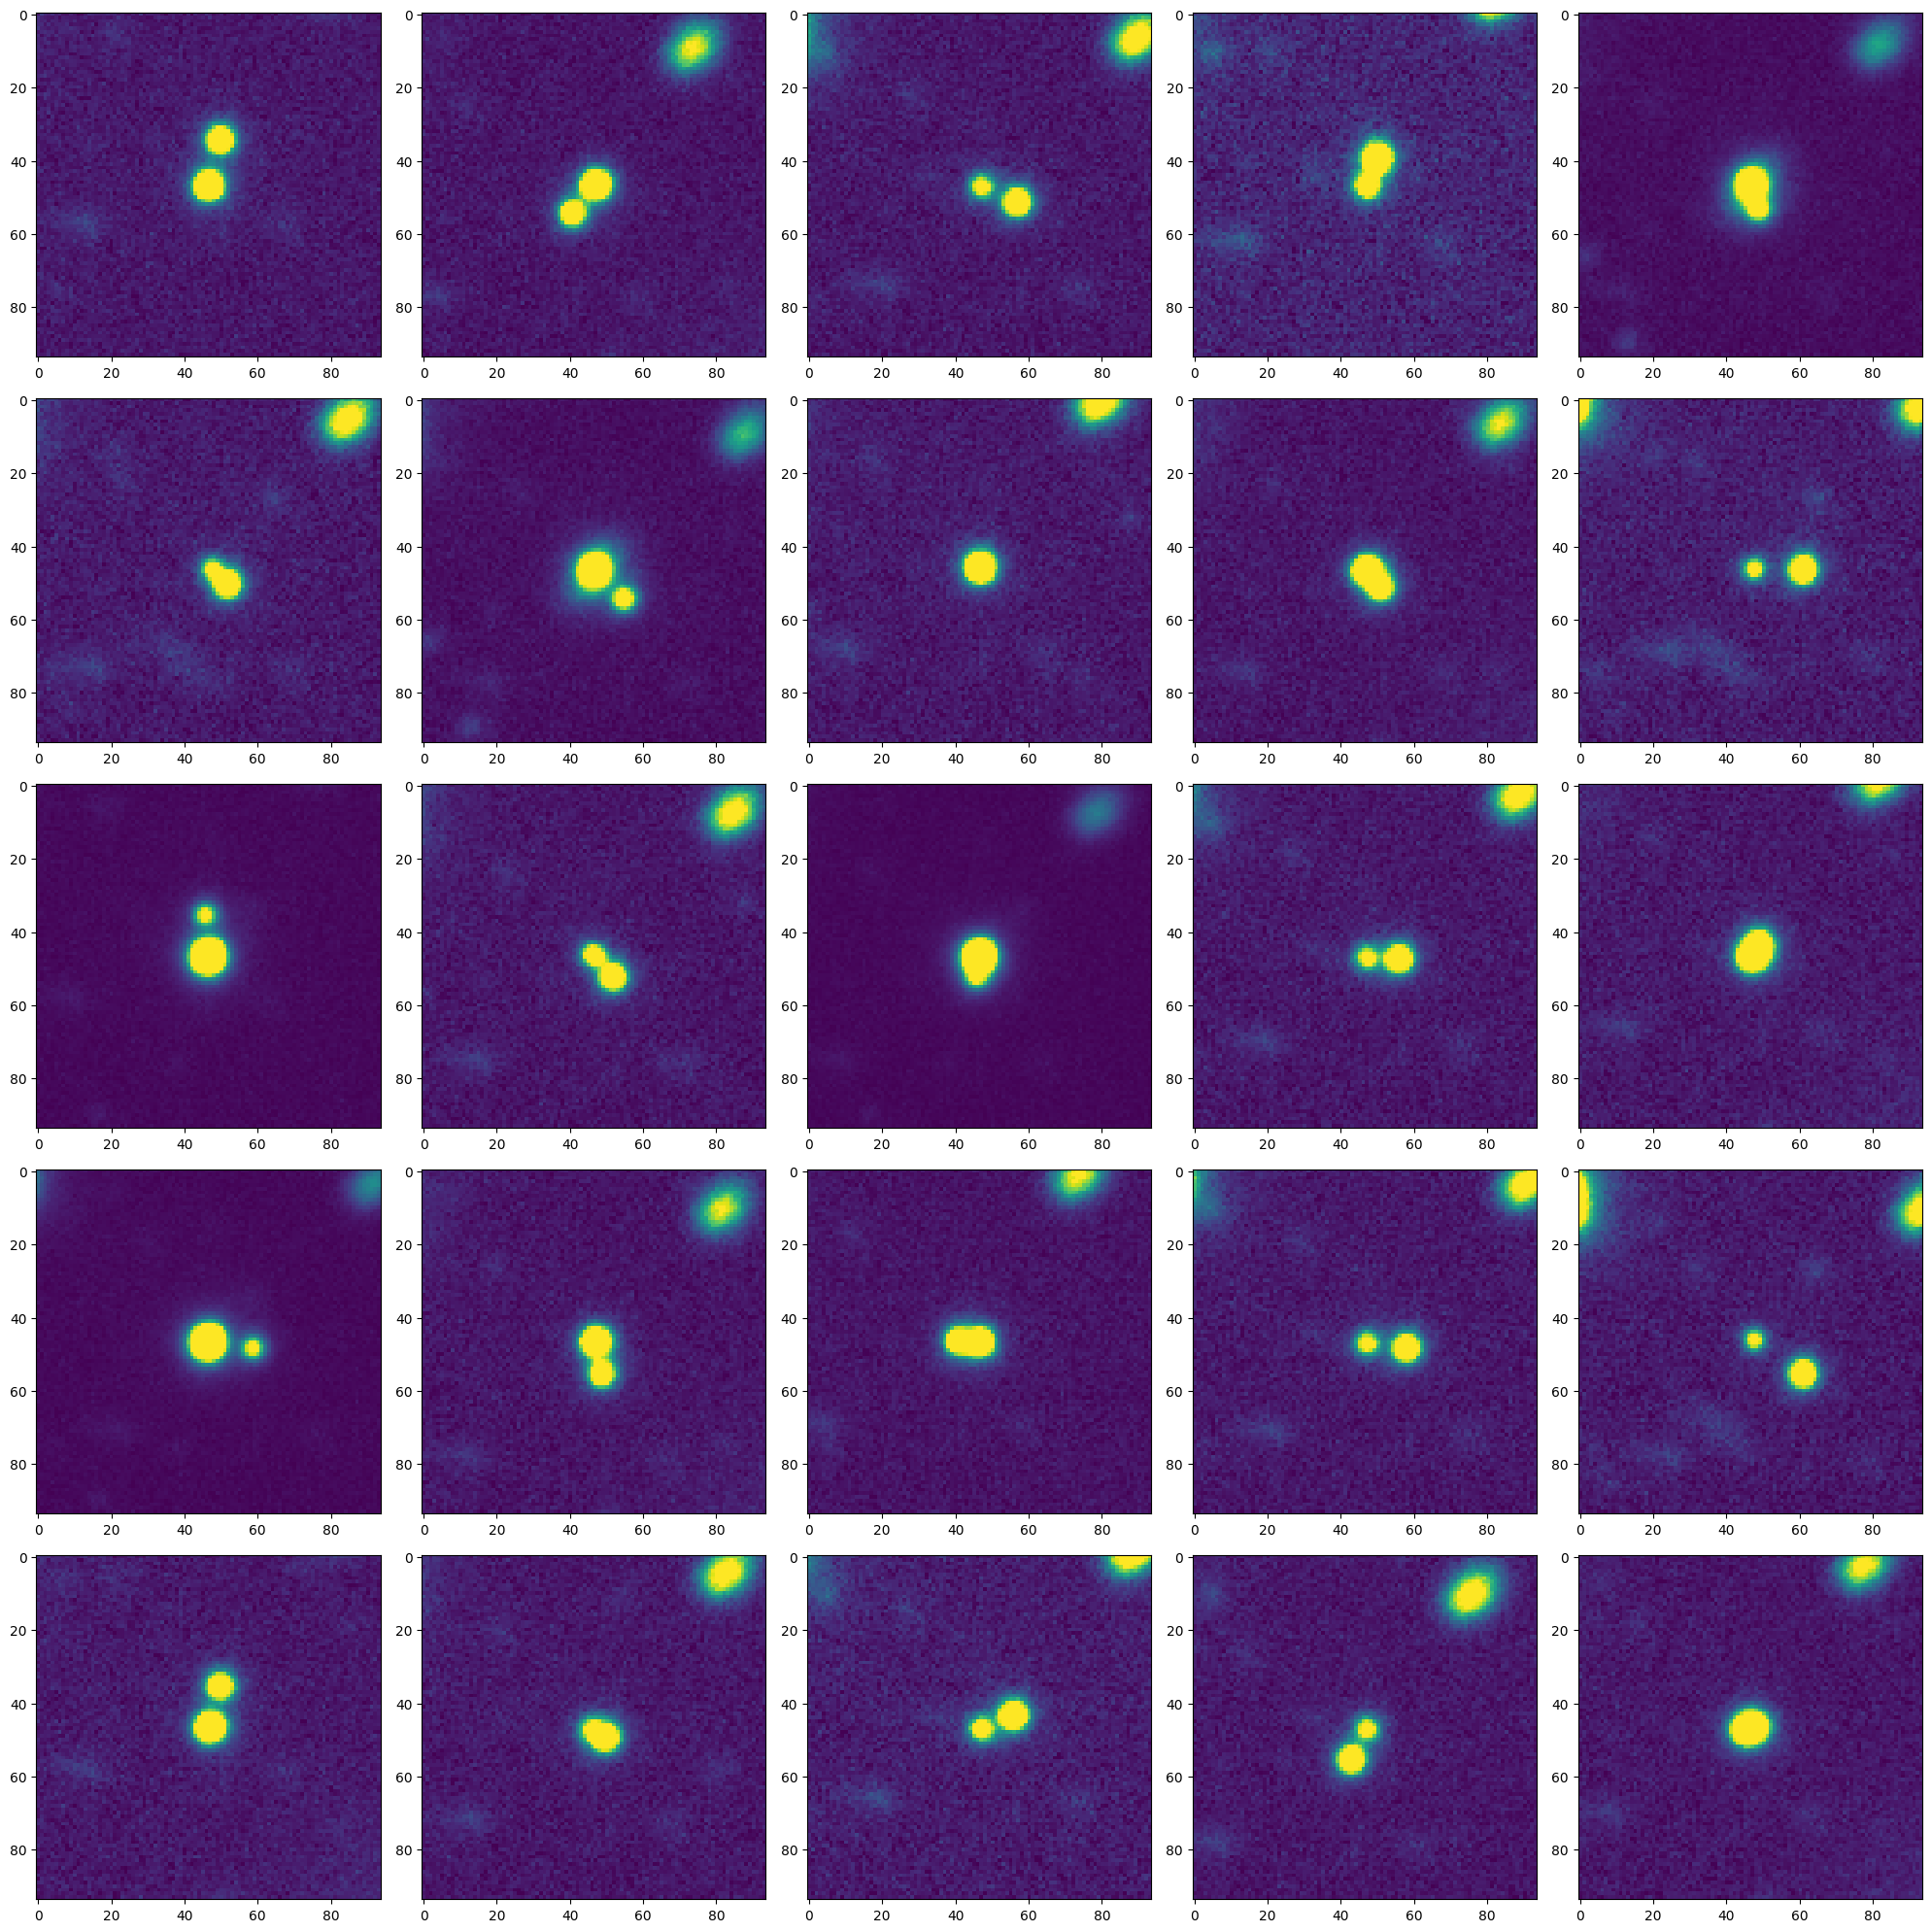

In [17]:
dual_training_images = []
for ii, image in tqdm(enumerate(glob.glob("data_preprocessing/training_datasets/dual_AGN_datasets/train_data/*.fits"))):
    with fits.open(image, memmap = False) as hdul:
        img = hdul[0].data
        if np.shape(img) != (94, 94):
            print(f"ERROR: image has shape {np.shape(img)}")
        dual_training_images.append(img)
        #print(f" {ii} images were successfully loaded, {image} is corrupted/could not be loaded")
    #except OSError:
random_dual_selection = np.random.choice(len(dual_training_images), size = 25)
fig, axes = plt.subplots(5, 5, figsize = (20,20))
counter = 0
for row in range(5):
    for col in range(5):
        img = dual_training_images[random_dual_selection[counter]]
        axes[row][col].imshow(img, vmin = np.percentile(img, 1), vmax = np.percentile(img, 99))
        counter += 1
plt.tight_layout()
plt.show()